# Detecting Credit Card Frauds Using RFC and GA
This notebook is an implementation of the genetic algorithm (GA) and random forest classifier (RFC) combination to uncover fraudulent transaction in a large dataset.

In [1]:
import time
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split

Let us first have a look at the dataset and what it looks like to get a better understanding of how to approach the problem

In [2]:
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


It seems that most of column names have been replaced with something arbitrary, nonetheless the values remain, which is what is most important to the dataset.

The first important aspect of any dataset is to check if it needs any cleaning and/or modification before we get started. Let first see if there are any missing values

In [3]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [4]:
df.isnull().values.any()

False

There are no null values in the dataframe at all, that concludes the cleaning!

## Data Exploration

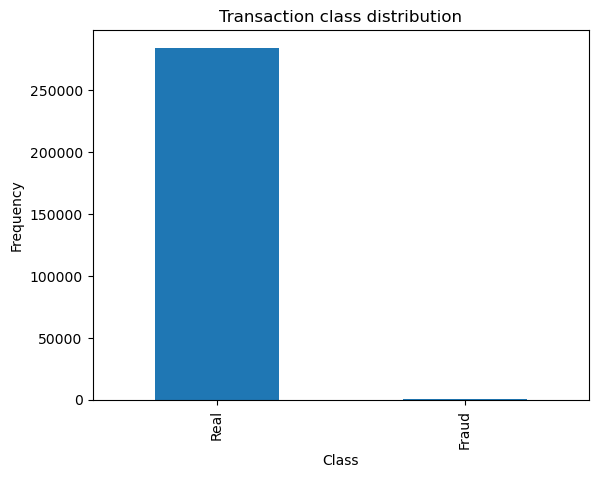

In [5]:
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar')
plt.title("Transaction class distribution")
plt.xticks(range(2), ['Real', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Frequency");

The dataset contains over 250,000 real transactions and only a few fraudulent ones, lets see how many there are exactly of each transaction.

In [6]:
frauds = df.loc[df.Class == 1]
real = df.loc[df.Class == 0]

In [7]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [8]:
real.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Looks like there are 492 frauds with 284,315 real transactions, the proportion of frauds is very small in comparison to the real transactions.

Lets see how the values of the trasnactions stack up to each other

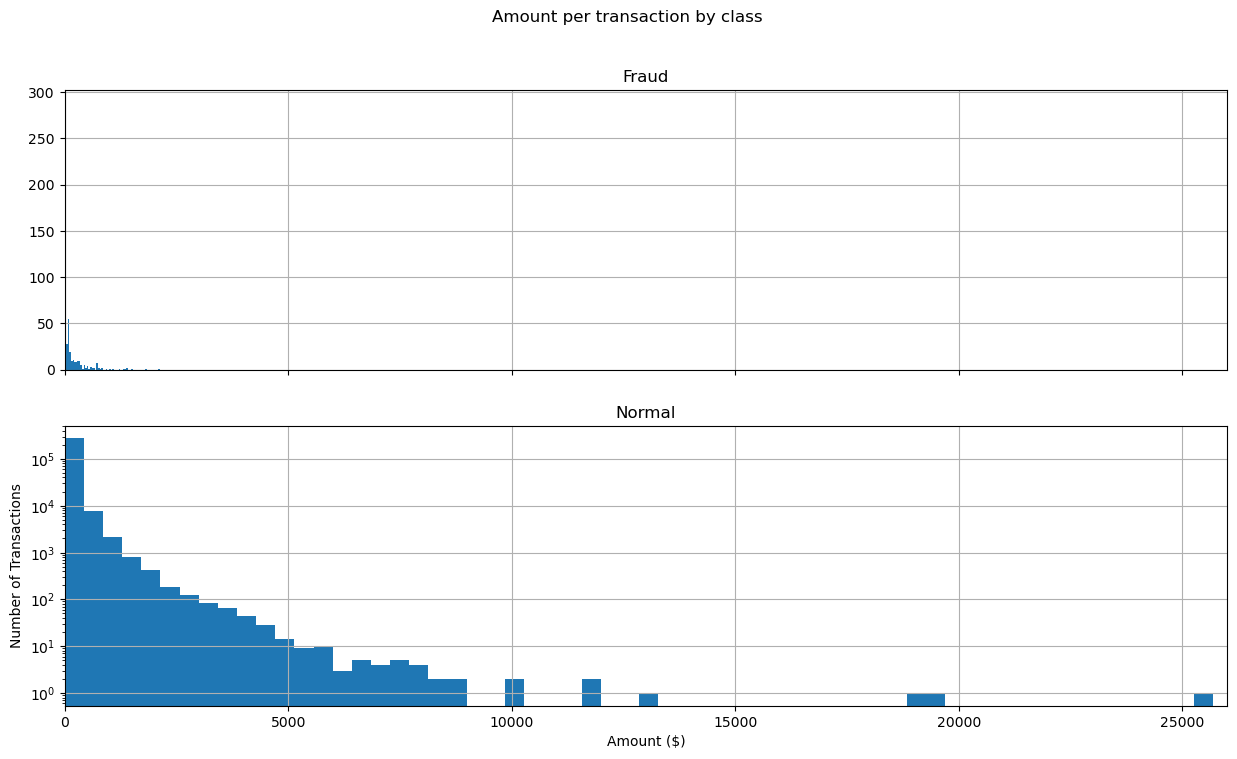

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
f.suptitle('Amount per transaction by class')

bins = 60

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')
ax1.grid(True)

ax2.hist(real.Amount, bins = bins)
ax2.set_title('Normal')
ax2.grid(True)

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 26000))
plt.yscale('log')
plt.show();

It looks like the fraudulent transactions are quite small in general, compared to the normal transactions. In fact, when we described the fraud dataframe, we saw that the maximum value was around 2,000. this is quite low compared to the max of just over 25,000 of the other dataframe. This could be something to keep in mind when building the model.

The other variable that we know is the time since the first transaction. Lets see if we can find something there.

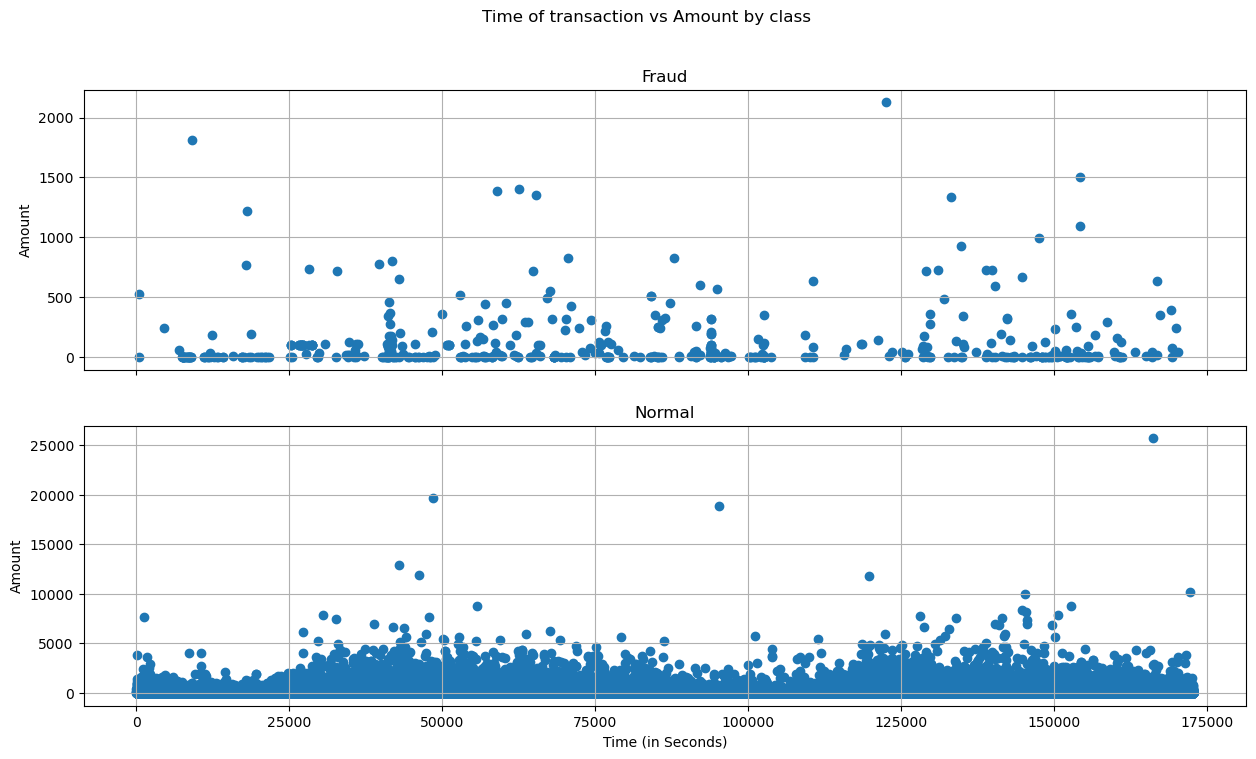

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')
ax1.set_ylabel('Amount')
ax1.grid(True)

ax2.scatter(real.Time, real.Amount)
ax2.set_title('Normal')
ax2.set_ylabel('Amount')
ax2.grid(True)

plt.xlabel('Time (in Seconds)')
plt.show()

The time of the transaction does not seem to have a big impact on whether the transaction is a fraud or not. Either way, since there are no more known variables that we can distinguis, lets dive into the model that we will be using.

# Genetic Algorithm Feature Selection with Random Forest Classifier
According to the following [paper](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00573-8]), credit card frauds can be detected with high accuracy and precision using the Genetic Algorithm (GA) feature selection process in combination with the Random Forrest classifier. However, since the dataset is highly skewed, it is not the best solution to use accuracy score, rather either recall, precision or F1 score are all better ways to measure the effectiveness of the model. In this notebook, I will use the F1 scoring method which uses a combination of recall and precision to come to a final score.

The reason we use a classifier over a regression is because the final predicted outcome is binary. 

The drawbacks of GAs is that they are computationally really heavy, which definetly a problem is this case, since the dataset has over 250,000 entries. There are two main changes we can make in order to reduce the computational need for this experiment.
1. Sample the data set and ensure there are enough fraudulent transactions in the sampled dataset.
2. Reduce the number of estimators in the tree.

Unfortunately, in this case I must opt to do both. For reasons I will explain later in this notebook, I have chosen to both reduce the dataset itself and the complexity of the model. This will highly reduce the computation costs.

In [11]:
frauds_in_sample = 0
while frauds_in_sample < 100:
    sampled_df = df.sample(n=int(len(df) / 5))
    frauds_in_sample = len(sampled_df[sampled_df['Class'] == 1])

X = sampled_df.drop("Class", axis=1)
y = sampled_df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Next, we define our fitness function.

The fitness function runs the RFC with 64 estimators and 8 parallel processes (I have an M1pro with 8 cores) to speed up the process. The function returns the f1 score of the model, which we will later try to maximize.

In [12]:
def get_fitness(individual, n_estimator: int = 64):
    rg = RandomForestClassifier(random_state=42, n_estimators=n_estimator, n_jobs=8)
    columns = [column for (column, binary_value) in zip(X_train.columns, individual) if binary_value]
    training_set = X_train[columns]
    test_set = X_test[columns]
    rg.fit(training_set.to_numpy(), y_train.values)
    preds = rg.predict(test_set.to_numpy())
    return f1_score(y_test, preds)

In [13]:
individual = [1] * 30
get_fitness(individual)

0.7692307692307693

In [14]:
random_individual = [random.randint(0, 1) for i in range(30)]
get_fitness(random_individual)

0.7179487179487181

## Genetic operations
The following functions have been taken from [this notebook](https://github.com/mtbisca/genetic-feature-selection/blob/master/Feature%20Selection%20using%20GA.ipynb), but haven been slightly altered in order to fit our model.
- `get_population_fitness` calls the `get_fitness` functions for each item in the population list.
- `build_next_generation` creates a new population list that will be run by the `get_population_fitness` function. It does this by taking the best fit of the previous population and a random one. Hereafter, the `tournament` function is called.
- `tournament` first creates a list of 5 random index numbers of the previous population. The scores of these 5 are translated to probabilities, with the highest score having the highest probability of being chosen. It then returns 2 new individuals created by `crossover`.
- `crossover` will split the 2 lists at a random point and combine it with the plit parts of the other list.
- `mutate` will pick a random feature and either turn it off or on. This is done so that there is enough variation in the population.

Since there are a little over 1 Billion possible combinations with 30 bits (2<sup>30</sup>), I prefer to choose breadth over depth. This is also one of the reasons I reduced complexity and computational needs in the model earlier. If I had access to more computational power, I would first increase the number of generation and mutations, before increasing the complexity of the model.

In [15]:
def get_population_fitness(population, n_estimator: int = 64):
    sorted_list = []
    for individual in population:
        individual_fitness = get_fitness(individual, n_estimator=n_estimator)
        sorted_list.append([individual, individual_fitness])

    return sorted(sorted_list, key=lambda tup: tup[1], reverse=True)

In [16]:
def build_next_generation(current_population, mutations):
    next_generation = [current_population[0][0], current_population[random.randint(1, len(current_population) - 1)][0]]
    for i in range(int((mutations - 2) / 2)):  # tournaments
        offspring_a, offspring_b = tournament(current_population)
        next_generation.append(offspring_a)
        next_generation.append(offspring_b)
        
    return next_generation


def tournament(current_population):
    index = sorted(random.sample(range(0, len(current_population)), 3))
    tournament_members = [current_population[i] for i in index]
    tournament_members = [[x[0], 1/(1-x[1])] for x in tournament_members]
    total_fitness = sum([individual[1] for individual in tournament_members])
    probabilities = [individual[1] / total_fitness for individual in tournament_members]
    index_a, index_b = np.random.choice(len(index), size=2, p=probabilities)
    return crossover(tournament_members[index_a][0], tournament_members[index_b][0])


def crossover(individual_a, individual_b):
    list_len = len(individual_b)
    crossing_point = random.randint(0, list_len-1)
    offspring_a = individual_a[0:crossing_point] + individual_b[crossing_point:list_len]
    offspring_b = individual_b[0:crossing_point] + individual_a[crossing_point:list_len]
    return mutate(offspring_a, offspring_b)

def mutate(individual_c, individual_d):
    first_index = random.randint(0, len(individual_c)-1)
    individual_c[first_index] = 1 if individual_c[first_index] == 0 else 0
    
    second_index = random.randint(0, len(individual_d)-1)
    individual_d[first_index] = 1 if individual_d[first_index] == 0 else 0
    
    return individual_c, individual_d


In [17]:
def run_ga(current_population, num_of_generations, mutations: int = 20, n_estimator: int = 70):
    fittest_individuals = []
    all_runs = []
    for i in range(num_of_generations):
        if ((i+1) == 1) or ((i+1) % 5 == 0):
            print(f"generation {i+1}")
        current_population = get_population_fitness(current_population, n_estimator=n_estimator)
        fittest_individuals.append(current_population[0])
        all_runs.append(current_population)
        current_population = build_next_generation(current_population, mutations) # make new population
    return fittest_individuals, all_runs


In [18]:
mutations = 5
estimators = 64
generations = 20
initial_population = [[1 for i in range(30)] for i in range(mutations)]

In [19]:
fittest, all_runs = run_ga(initial_population, generations, mutations=mutations, n_estimator=estimators)

generation 1
generation 5
generation 10
generation 15
generation 20


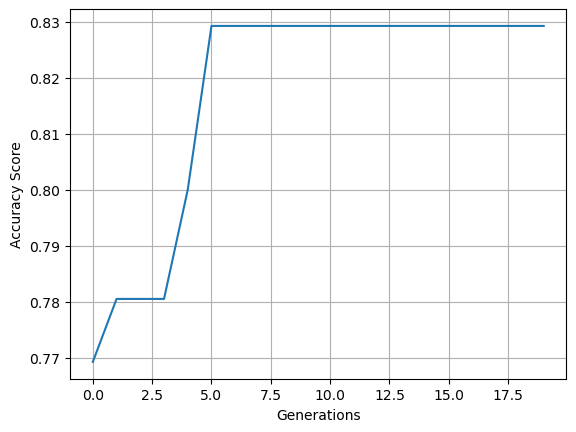

In [20]:
fitness = [ind[1] for ind in fittest]

plt.plot(fitness);
plt.xlabel('Generations')
plt.ylabel('Accuracy Score')
plt.grid()
plt.show()

As one can see, the accuracy has not changed at all over the course of the 20 generations. This likely means that there are multiple combinations of columns that yield the same high accuracy.

One potential improvement for this is to not sample the data. However, this would take too long for me to run is thus not possible for me to do. If I had the computing power, I would not sample the original data set, use higher number of estimators in the RandomForestClassifier and increase the population and generations.

In [21]:
included_columns = [column for (column, binary_value) in zip(X.columns, individual) if binary_value]
excluded_columns = [column for (column, binary_value) in zip(X.columns, individual) if not binary_value]
included_columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

Looks like our quick hypothesis about the transaction time was correct - irrelevant.

Lets test the best solution that we came up with with the full dataset.

In [22]:
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
individual = fittest[-1][0]
rg = RandomForestClassifier(random_state=42, n_estimators=128, n_jobs=8, verbose=1)
columns = [column for (column, binary_value) in zip(X_train.columns, individual) if binary_value]
training_set = X_train[columns]
test_set = X_test[columns]
rg.fit(training_set.to_numpy(), y_train.values)
preds = rg.predict(test_set.to_numpy())

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:   29.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


In [23]:
preds_1 = np.where(preds == 1)
y_test.reset_index(drop=True, inplace=True)

In [24]:
heatmap_cm = confusion_matrix(y_test, preds)

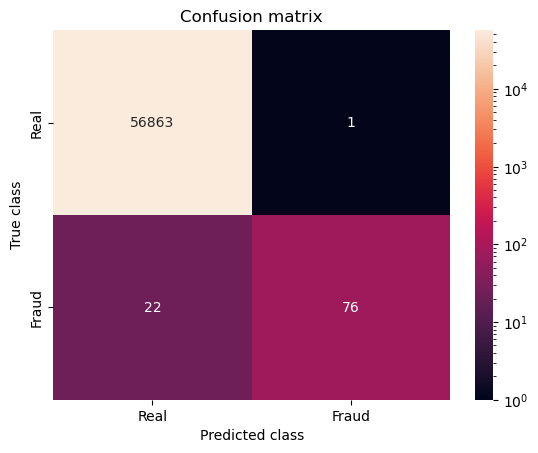

In [25]:
LABELS = ["Real", "Fraud"]
sns.heatmap(heatmap_cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", norm=LogNorm());
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

As we can see from the confusion matrix, there is only 1 type 1 error, but unfortunately there are a few type 2 errors. It will be difficult to distinguish them later on, but if this model were to be implemented, one can be almost 100% certain if the model detects a fraud that it is a fraud.

What is nice is that this model is definitely an improvement over the model that the original author proposed, altough run times are slightly longer. The reason that this ML model is an improvement, is because it catches almost the same amount of true fraud cases, but has almost no type 1 errors.

# Conclusion
With the help of the original paper on best ML models to detect credit card frauds, it was possible to improve the accuracy of the intial author where the data set was gathered from, especially the type 1 errors.

There is, however, still room for improvement, as there are still quite a few type 2 errors. This could be done by increasing the number of generations and the population set, as well as using more of the original data set. I believe that all of these improvements would decrease the type 2 errors. Even if it slightly increases the type 1 errors by doing so, it would be worth it. Because someone at the bank who is checking the transaction can quickly notify a few customers who are type 1 errors. Yet if this number gets into the thousands, it would not be acceptable anymore.